In [51]:
import pandas as pd
import seaborn as sns
from dateutil import parser
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()
import matplotlib.pyplot as plt
%matplotlib inline

# Running Pace Exploration

In this project, I'm going to investigate how different factors affect my running pace. Intuitively, runners know that things like elevation gain and temperature affect performance, but <i>how much</i>, exactly, does this affect pace?

Runs were logged with Strava, and heart rate data was collected using a Polar H10 chest strap over most of 2021.


# Strava Data

You can request all of your Strava user data from the Delete Account page (https://www.strava.com/athlete/delete_your_account). Summary statistics are located in activities.csv.

<b>Note:</b> Strava data is in SI units.


In [203]:
# Read in Strava statistics and find columns of interest
strava_df = pd.read_csv('activities.csv', parse_dates=True, index_col='Activity Date')
print(strava_df.columns)

Index(['Activity ID', 'Activity Name', 'Activity Type', 'Activity Description',
       'Elapsed Time', 'Distance', 'Max Heart Rate', 'Relative Effort',
       'Commute', 'Activity Gear', 'Filename', 'Athlete Weight', 'Bike Weight',
       'Elapsed Time.1', 'Moving Time', 'Distance.1', 'Max Speed',
       'Average Speed', 'Elevation Gain', 'Elevation Loss', 'Elevation Low',
       'Elevation High', 'Max Grade', 'Average Grade',
       'Average Positive Grade', 'Average Negative Grade', 'Max Cadence',
       'Average Cadence', 'Max Heart Rate.1', 'Average Heart Rate',
       'Max Watts', 'Average Watts', 'Calories', 'Max Temperature',
       'Average Temperature', 'Relative Effort.1', 'Total Work',
       'Number of Runs', 'Uphill Time', 'Downhill Time', 'Other Time',
       'Perceived Exertion',
       '<span class="translation_missing" title="translation missing: en-US.lib.export.portability_exporter.activities.horton_values.type">Type</span>',
       '<span class="translation_missing"

From these categories, I'll need:

1. Average Speed
1. Average Heart Rate
1. Elevation Gain

For all runs in 2021.

In [204]:
# Filter for only 2021 activities and runs only. Remove any rows with NaNs.
run_df = strava_df.loc['2021-01-01':]
run_df = run_df[run_df['Activity Type'] == 'Run'][['Average Speed', 'Average Heart Rate', 'Elevation Gain']]
run_df = run_df.dropna()

# Let's also add units to the columns for completeness
run_df.columns = ['Average Speed (m/s)', 'Average Heart Rate (BPM)', 'Elevation Gain (m)']

In [205]:
run_df.head()

,Average Speed (m/s),Average Heart Rate (BPM),Elevation Gain (m)
Activity Date,,,
2021-01-29 00:52:58,3.502933,183.166321,15.317184
2021-01-26 00:05:07,2.457140,166.639969,301.950714
2021-01-22 23:50:27,2.295785,174.350204,298.129578
2021-01-19 00:05:15,2.104529,170.672272,501.487457
2021-01-13 20:36:58,2.447490,172.626175,165.052643


In [206]:
# Convert average speed from km/h to mi/h
run_df['Average Speed (mi/h)'] = run_df['Average Speed (m/s)'] * 2.23694

# Convert elevation gain from m to ft
run_df['Elevation Gain (ft)'] = run_df['Elevation Gain (m)'] * 3.28084 # m to ft

# Pace is a more common way of looking at running speed
run_df['Pace (minutes/mi)'] = 60 / run_df['Average Speed (mi/h)']

# Get rid of unnecessary columns
run_df.drop(['Average Speed (m/s)', 'Elevation Gain (m)', 'Average Speed (mi/h)'], axis=1, inplace=True) 

# In order to join the Strava DataFrame and the weather DataFrame, they need to have the same indicies.
# Both are currently DataTime objects, but the Strava data is more precise--all I care about is the year,
# month, and day an acvitivty occurred.
# I'm pretty sure I never ran more than once per day. In case I did, average the two runs.
run_df = run_df.resample('D').mean()
run_df = run_df.dropna()

In [207]:
run_df.head()

,Average Heart Rate (BPM),Elevation Gain (ft),Pace (minutes/mi)
Activity Date,,,
2021-01-11,158.231827,570.478182,12.675762
2021-01-13,172.626175,541.511313,10.959126
2021-01-19,170.672272,1645.300109,12.745065
2021-01-22,174.350204,978.115443,11.683304
2021-01-26,166.639969,990.651981,10.916089


# Weather Data

Weather data was obtained from http://www.ncdc.noaa.gov/cdo-web/search. For this exercise, I'm going to use the maximum temperature recorded in my city. I mostly run during daylight hours and within several hours of the hottest part of the day. That said, this is a major assumption, and I'd expect any effect of temperature to be an overprediction.  

In [208]:
# Read in NOAA data
weather_df = pd.read_csv('2818194.csv', parse_dates=True, index_col='DATE')
weather_df.columns

Index(['STATION', 'NAME', 'TMAX', 'TMIN'], dtype='object')

In [209]:
# Drop everything except TMAX and rename
weather_df.drop(['STATION', 'NAME', 'TMIN'], axis=1, inplace=True)
weather_df.columns = ['Maximum temperature (\u00B0F)']

In [210]:
weather_df.head()

,Maximum temperature (°F)
DATE,
2020-10-13,65.0
2020-10-14,62.0
2020-10-15,63.0
2020-10-16,70.0
2020-10-17,69.0


In [211]:
# Now, let's do an inner join on the two DataFrames
all_df = run_df.join(weather_df, how='inner') 
all_df.head()

,Average Heart Rate (BPM),Elevation Gain (ft),Pace (minutes/mi),Maximum temperature (°F)
2021-01-11,158.231827,570.478182,12.675762,51.0
2021-01-13,172.626175,541.511313,10.959126,59.0
2021-01-19,170.672272,1645.300109,12.745065,52.0
2021-01-22,174.350204,978.115443,11.683304,48.0
2021-01-26,166.639969,990.651981,10.916089,38.0


In [212]:
# Check for any missing data
all_df.isnull().values.any()

False

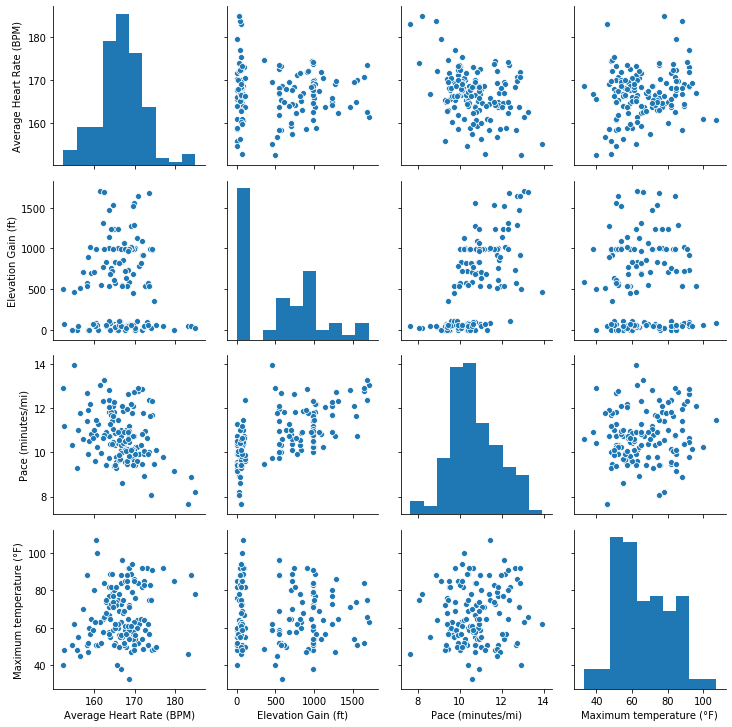

In [224]:
sns.pairplot(all_df)

# Correlation Heatmap

To get a quick idea of how much change in each variable is explained by another, I'll use a heatmap.

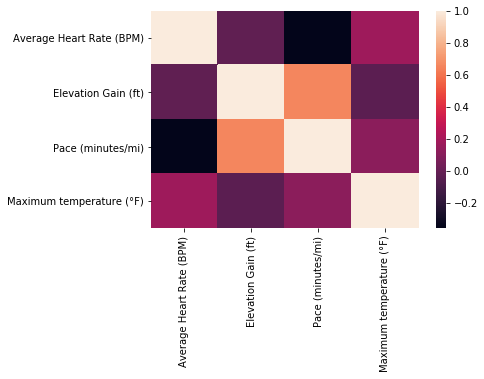

In [213]:
sns.heatmap(all_df.corr())

From the heatmap, it looks like pace and elevation gain have a strong positive correlation. Conversely, pace and average heart rate are slightly negatively correlated. Again, these all make intuitive sense to a runner. Let's quantify how much each feature actually affects another using a linear regression model.

In [214]:
# Try and predict pace 
X = all_df[['Average Heart Rate (BPM)', 'Elevation Gain (ft)', 'Maximum temperature (\u00B0F)']]
y = all_df['Pace (minutes/mi)']

In [215]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [216]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [217]:
# Look at model's coefficients
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Average Heart Rate (BPM),-0.069272
Elevation Gain (ft),0.001481
Maximum temperature (°F),0.016254


The units for the coefficients are in minutes/mile. Let's convert them to seconds/mile:

In [218]:
coeff_df * 60

,Coefficient
Average Heart Rate (BPM),-4.156321
Elevation Gain (ft),0.088879
Maximum temperature (°F),0.975223


According to this model:
- An <b>increase of average heart rate of 1 BPM decreases average pace by 4.16 s</b>, holding all other features constant.
- For each <b>1 ft of elevation gain during the run, average pace increases by 0.09 s</b>, holding all other features constant.
- An <b>increase of 1°F of daily maximum temperature increases average pace by 0.98 s</b>, holding all other features constant.


# Predictions

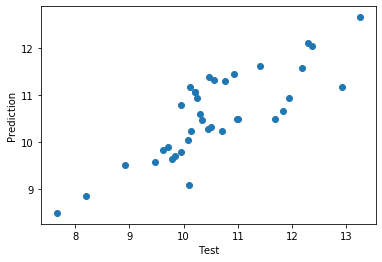

In [223]:
predictions = lm.predict(X_test)
plt.xlabel('Test')
plt.ylabel('Prediction')
plt.scatter(y_test, predictions)

Ideally, these datapoints would form a straight line. However, the relationship between test and prediction is approximately linear.

# Residuals

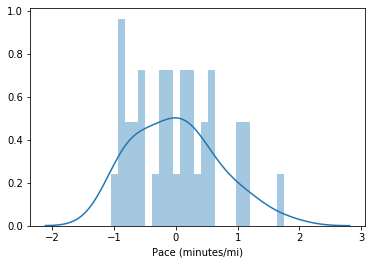

In [222]:
sns.distplot((y_test-predictions),bins=25);

With more training data, it looks like the residuals would approach a Gaussian distribution.

# Conclusions

* Add grade